# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 17 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [2]:
RANDOM_STATE = 42

# Apartado 1: Clasificador de noticias

__Número de grupo: 4__

__Nombres de los estudiantes: Fernando de la Gándara Fernández, Jaime Martínez Gamero, Laura Marta Marco Simal__

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no debes usarlo para clasificar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías. Indica si debemos tenerlo en cuenta de alguna forma al analizar los modelos que construyamos.

Muestra un mensaje cualquiera y explica si lo habrías clasificado en la clase correcta tras leerlo.

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [61]:
df_bbc = pd.read_csv('BBC News.csv', index_col = 0)

In [84]:
df_bbc

,Text,Category
ArticleId,,
1833,worldcom ex-boss launches defence lawyers defe...,business
154,german business confidence slides german busin...,business
1101,bbc poll indicates economic gloom citizens in ...,business
1976,lifestyle governs mobile choice faster bett...,tech
917,enron bosses in $168m payout eighteen former e...,business
...,...,...
857,double eviction from big brother model caprice...,entertainment
325,dj double act revamp chart show dj duo jk and ...,entertainment
1590,weak dollar hits reuters revenues at media gro...,business


In [76]:
df_percentage = df_bbc['Category'].value_counts()/df_bbc.count()[0]
df_percentage


sport            0.232215
business         0.225503
politics         0.183893
entertainment    0.183221
tech             0.175168
Name: Category, dtype: float64

In [77]:
df_bbc.groupby('Category').describe()

Text                                                            \
              count unique                                                top   
Category                                                                        
business        336    335  economy  strong  in election year uk businesse...   
entertainment   273    263  stars pay tribute to actor davis hollywood sta...   
politics        274    266  mps issued with blackberry threat mps will be ...   
sport           346    342  ferguson rues failure to cut gap boss sir alex...   
tech            261    234  ask jeeves joins web log market ask jeeves has...   

                    
              freq  
Category            
business         2  
entertainment    2  
politics         2  
sport            2  
tech             2

Podemos ver que es un dataset decentemente equilibrado, pues la diferencia de cantidad de elementos entre categorías es aceptable. Cabe destacar una mayor carga de textos "business" o categoría de empresa frente a una menor de tecnológicas.

Veamos que esta proporción es aceptable de forma más gráfica usando un diagrama de tarta:

<AxesSubplot:ylabel='Category'>

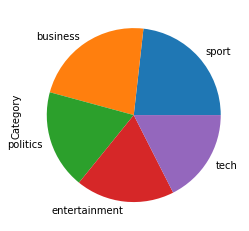

In [32]:
df_bbc['Category'].value_counts().plot.pie()

In [78]:
#TODO Leer teoría y ver como afecta que haya más clases de un tipo que de otro

In [79]:
df_bbc['Text'][101]

'housewives lift channel 4 ratings the debut of us television hit desperate housewives has helped lift channel 4 s january audience share by 12% compared to last year.  other successes such as celebrity big brother and the simpsons have enabled the broadcaster to surpass bbc two for the first month since last july. bbc two s share of the audience fell from 11.2% to 9.6% last month in comparison with january 2004. celebrity big brother attracted fewer viewers than its 2002 series.  comedy drama desperate housewives managed to pull in five million viewers at one point during its run to date  attracting a quarter of the television audience. the two main television channels  bbc1 and itv1  have both seen their monthly audience share decline in a year on year comparison for january  while five s proportion remained the same at a slender 6.3%. digital multi-channel tv is continuing to be the strongest area of growth  with the bbc reporting freeview box ownership of five million  including on

Hemos analizado el texto en profundidad y hemos descartado rápidamente que se tratara de un elemento de la categoría "sports" o "tech" ya que no usa términos de distintos deportes o especializados en tecnología (chips, sistemas operativos, etc). Al ver que habla de diversos programas de televisión, como comedias, gran hermano o los simpsons, llegamos a la conclusión de que debería de ser un texto de entretenimiento. Comprobemos si hemos acertado:

In [81]:
df_bbc['Category'][101]

'entertainment'

Como se puede ver, hemos acertado y lo hemos hecho gracias a analizar palabras clave del texto y las relaciones semánticas que tenemos asociadas debido a nuestro aprendizaje diario. Esta idea será una de las que usaremos para establecer una correlación entre textos y categorías.

Ahora hagamos la partición entre conjunto de entrenamiento y de prueba en una proporción 80-20. Esta partición nos servirá más adelante para estudiar de mejor modo el error de cada modelo.

In [85]:
np_bbc_target = df_bbc['Category'].to_numpy()
np_bbc_input = df_bbc['Text'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(np_bbc_input, np_bbc_target , 
                                                    test_size=0.20, stratify=np_bbc_target,
                                                    random_state= RANDOM_STATE)

In [88]:
print("Textos de entrenamiento:", len(X_train))
print("Textos de prueba:", len(X_test))
print("Textos totales",len(X_test) + len(X_train))

Textos de entrenamiento: 1192
Textos de prueba: 298
Textos totales 1490


## 2) Representación basada en bolsa de palabras y frecuencia de aparición

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y la frecuencia de aparición de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Entrena un clasificador Naive Bayes Multinomial y calcula su tasa de aciertos sobre el conjunto de entrenamiento y el conjunto de test. A continuación calcula los valores de precisión, exhaustividad y puntuación F1 para cada una de las clases. Dibuja la matriz de confusión. Analiza los resultados obtenidos.

A continuación, entrena un clasificador k-NN con la configuración por defecto y usando la misma vectorización. Analiza los resultados, ¿a qué crees que se deben?

Primero de todo, realizaremos la vectorización que infiere la información del mismo conjunto de entrenamiento sin usar el diccionario externo.

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [116]:
vectorizer = CountVectorizer(stop_words='english', binary=False)
# Tomamos los textos del conjunto de entrenamiento y los transformamos en 
# una matriz de datos (palabras) según el diccionario estándar
train_vector_data=vectorizer.fit_transform(X_train)


In [117]:
feature_names = vectorizer.get_feature_names()

print(len(feature_names))
print(feature_names[:5000])

22260
['00', '000', '0001', '000m', '000th', '001', '001and', '001st', '0051', '007', '01', '0100', '0130', '028', '03', '033', '04', '0400', '041', '04bn', '04secs', '05', '050', '050505', '0530gmt', '056', '05bn', '05m', '06', '060', '07', '070', '0710', '072', '0730', '08', '080', '0800', '0845', '0870', '088', '09', '0900', '0950', '09bn', '09secs', '10', '100', '1000th', '100bn', '100m', '100ml', '101', '102', '103', '104', '105', '105bn', '106', '106m', '107', '108', '1080', '109', '109m', '10bn', '10ft', '10m', '10secs', '10th', '11', '110', '1100', '110m', '110th', '111', '111m', '112', '113', '1130', '1130p', '113bn', '115', '116', '116i', '117', '117m', '119', '119bn', '119m', '11bn', '11m', '11pm', '11th', '12', '120', '1200', '1200m', '120bn', '120gb', '120m', '121', '1215', '1230', '124bn', '125', '125m', '126', '127th', '128', '129', '12a', '12bn', '12cm', '12m', '12th', '13', '130', '1300', '130m', '132', '133', '1330', '1337', '133m', '134', '135', '137', '137m', '138m'

In [119]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [120]:
write_terms(feature_names, None, train_vector_data, 12)

write_terms(feature_names, None, train_vector_data, 123)

Mensaje 12 vectorizado: ['12' '16' '24' 'ability' 'accused' 'adding' 'allies' 'amazing' 'ashamed'
 'awol' 'backsides' 'bbc' 'began' 'betrayal' 'betraying' 'break'
 'bringing' 'britain' 'brussels' 'called' 'came' 'campaign' 'candidate'
 'challenged' 'champagne' 'change' 'changed' 'chat' 'clear' 'committee'
 'complaint' 'confirm' 'constituency' 'constituents' 'content' 'contested'
 'continue' 'conviction' 'criminal' 'decision' 'did' 'disciplinary'
 'disrepute' 'doing' 'dominated' 'east' 'election' 'elections'
 'embarrassed' 'end' 'energy' 'europe' 'european' 'ex' 'explained'
 'expulsion' 'failed' 'fat' 'fellow' 'flood' 'form' 'formal' 'general'
 'genuine' 'going' 'gone' 'goodbye' 'govern' 'growing' 'happen' 'helped'
 'hinckley' 'host' 'idea' 'independence' 'influence' 'initially'
 'interested' 'joined' 'joke' 'june' 'just' 'kilroy' 'knapman' 'knowing'
 'labelled' 'latin' 'leader' 'leadership' 'leave' 'leicestershire' 'marks'
 'masses' 'meeting' 'member' 'membership' 'mep' 'meps' 'midland

Esta vectorización, como se puede ver, añade un grupo amplio de términos de ruido, principalmente alfanuméricos que en general no aportarán demasiado y podrían complicar el aprendizaje de nuestros modelos. Ahora procederemos a ejecutar la segunda vectorización, que se basará en el diccionario inglés dado en la práctica. Originalmente hemos pensado que este diccionario podría dejar de lado algunas palabras para clasificar, y aunque será cierto en casos concretos, en general es bastante amplio e incorpora términos como "batman" y "simpson", bastante de la jerga y que  ayudan al algoritmo.

## 3) Representación basada en word-embeddings

La segunda vectorización que vamos a usar representará los mensajes usando word-embeddings. Cada documento se representará como el vector que resulta de promediar los embeddings de cada una de sus palabras. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings. 

Entrena un clasificador Naive Bayes Gaussiano (el Multinomial no admite valores negativos que sí aparecen en los embeddings). Analiza el error por clase y dibuja la matriz de confusión.

Entrena otro clasificador kNN con la nueva vectorización y la configuración por defecto y analiza su error.

## 4) Análisis comparativo final

Hemos entrenado dos clasificadores usando dos vectorizaciones diferentes de los datos. Compara la tasa de acierto de todos ellos y explica a qué crees que se deben las diferencias.

Busca un mensaje mal clasificado por el Naive Bayes con vectorización de frecuencias y otro mal clasificado por el k-NN con Word-embeddings. Analiza los vectores de términos de dichos mensajes e intenta razonar por qué ha sido clasificado erróneamente.

Para el Naive Bayes con vectorización de frecuencias, elige dos clases donde el clasificador no haya funcionado bien y analiza las palabras más relevantes para clasificar una noticia como de dichas clases. Razona si lo que ves crees que influye en la posible confusión a la hora de clasificar entre dichas clases.